In [1]:
!pip install timm
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install torch torchvision transformers pycocotools pillow numpy matplotlib

#YOU HAVE TO RESTART YOU ENVIRONMENT HERE
#CLICK Menu -> Runtime -> Restart Session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, DetrForSegmentation
from pycocotools.coco import COCO
from PIL import Image
import numpy as np


In [3]:
#Ici on va telecharger le dataset COCO.

!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip


--2024-04-20 12:40:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.43.121, 52.217.115.97, 52.217.118.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.43.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  31.6MB/s    in 26s     

2024-04-20 12:40:40 (30.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2024-04-20 12:40:40--  http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.97.244, 52.216.41.81, 52.216.108.243, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.97.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860725834 (821M) [application/zip]
Saving to: ‘panoptic_annotations_trainval2017.zip’

In [4]:
!unzip val2017.zip
!unzip panoptic_annotations_trainval2017.zip
!unzip ./annotations/panoptic_val2017.zip -d ./annotations/

!rm val2017.zip
!rm panoptic_annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./annotations/panoptic_val2017/000000489014.png  
  inflating: ./annotations/panoptic_val2017/000000201775.png  
  inflating: ./annotations/panoptic_val2017/000000245651.png  
  inflating: ./annotations/panoptic_val2017/000000446117.png  
  inflating: ./annotations/panoptic_val2017/000000215072.png  
  inflating: ./annotations/panoptic_val2017/000000119828.png  
  inflating: ./annotations/panoptic_val2017/000000523957.png  
  inflating: ./annotations/panoptic_val2017/000000309467.png  
  inflating: ./annotations/panoptic_val2017/000000090956.png  
  inflating: ./annotations/panoptic_val2017/000000283038.png  
  inflating: ./annotations/panoptic_val2017/000000035326.png  
  inflating: ./annotations/panoptic_val2017/000000546659.png  
  inflating: ./annotations/panoptic_val2017/000000020059.png  
  inflating: ./annotations/panoptic_val2017/000000516708.png  
  inflating: ./annotations/panoptic_val2017/000000284743.png  
  in

In [11]:
# Maintenant, afin d'utiliser l'API COCO dataset, nous devons convertir son format d'annotation panoptique en un format spécifique qui fonctionnerait pour l'API.
# Le fichier source provient de l'api panoptic, mais il était nécessaire de modifier manuellement un fichier source. D'ou l'importation d'un repo github différent ci dessous.


In [8]:
!wget https://raw.githubusercontent.com/jessyaz/PANOPTIC_COCO_DETR/main/panoptic2detection_coco_format.py
!wget https://raw.githubusercontent.com/jessyaz/PANOPTIC_COCO_DETR/main/panoptic_coco_categories.json

--2024-04-20 12:47:10--  https://raw.githubusercontent.com/jessyaz/PANOPTIC_COCO_DETR/main/panoptic2detection_coco_format.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6417 (6.3K) [text/plain]
Saving to: ‘panoptic2detection_coco_format.py’

panoptic2detection_ 100%[===================>]   6.27K  --.-KB/s    in 0s      

2024-04-20 12:47:10 (46.5 MB/s) - ‘panoptic2detection_coco_format.py’ saved [6417/6417]

--2024-04-20 12:47:10--  https://raw.githubusercontent.com/jessyaz/PANOPTIC_COCO_DETR/main/panoptic_coco_categories.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP r

In [9]:
!python3 panoptic2detection_coco_format.py --input_json_file './annotations/panoptic_val2017.json' --output_json_file 'panoptic_annotations.json'

CONVERTING...
COCO panoptic format:
	Segmentation folder: ./annotations/panoptic_val2017
	JSON file: ./annotations/panoptic_val2017.json
TO
COCO detection format
	JSON file: panoptic_annotations.json


Reading annotation information from ./annotations/panoptic_val2017.json
Number of cores: 2, images per core: 2500
Core: 0, 0 from 2500 images processed
Core: 1, 0 from 2500 images processed
Core: 0, 100 from 2500 images processed
Core: 1, 100 from 2500 images processed
Core: 0, 200 from 2500 images processed
Core: 1, 200 from 2500 images processed
Core: 0, 300 from 2500 images processed
Core: 1, 300 from 2500 images processed
Core: 0, 400 from 2500 images processed
Core: 1, 400 from 2500 images processed
Core: 0, 500 from 2500 images processed
Core: 1, 500 from 2500 images processed
Core: 0, 600 from 2500 images processed
Core: 1, 600 from 2500 images processed
Core: 0, 700 from 2500 images processed
Core: 1, 700 from 2500 images processed
Core: 1, 800 from 2500 images processed
Core: 0,

In [10]:
#Lien des annotations du dataset
ANNOTATIONS_FILE = 'panoptic_annotations.json'

#Lien du dossier des images du dataset
image_dir = './val2017/'

# Chargement du fichier d'annotations
coco = COCO(ANNOTATIONS_FILE)

# Chargement des IDs des images
image_ids = coco.getImgIds()

# Seuil de confiance pour considérer un segment détecté comme positif
CONFIDENCE_THRESHOLD = 0.90

# Nombre d'images à afficher
NUM_IMAGES_TO_DISPLAY = 3

# Initialisation du processeur d'images et du modèle
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")


loading annotations into memory...
Done (t=1.72s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/172M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
def calculate_iou(boxA, boxB):
    """
    Calcul l'Intersection over Union (IoU).

    Args:
    - pred_bbox : Liste [xmin, ymin, xmax, ymax] des coordonnées de la boîte englobante prédite.
    - gt_bbox : Liste [xmin, ymin, width, height] des coordonnées de la boîte englobante de l'annotation.

    Les deux boundingbox n'ont pas les mêmes coordonénes

    Returns:
    - iou : l'Intersection over Union (IoU).
    """

    xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_bbox

    xmin_gt, ymin_gt, width_gt, height_gt = gt_bbox

    x_left = max(xmin_pred, xmin_gt)
    y_top = max(ymin_pred, ymin_gt)
    x_right = min(xmax_pred, xmin_gt + width_gt)
    y_bottom = min(ymax_pred, ymin_gt + height_gt)

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    gt_area = width_gt * height_gt
    union_area = pred_area + gt_area - intersection_area

    iou = intersection_area / union_area

    return iou



In [13]:
def is_bbox_match(pred_bbox, gt_bbox, iou_threshold=0.5):
    """
    Vérifie si deux bounding boxes correspondent en utilisant l'Intersection over Union (IoU) avec un seuil donné.

    Args:
    - pred_bbox : Liste [xmin, ymin, xmax, ymax] des coordonnées de la boîte englobante prédite.
    - gt_bbox : Liste [xmin, ymin, width, height] des coordonnées de la boîte englobante de l'annotation.
    - iou_threshold : Seuil d'Intersection over Union (IoU) pour considérer les boîtes comme correspondantes.

    Returns:
    - match : True si les boîtes correspondent en fonction du seuil IoU, False sinon.
    """

    xmin_pred, ymin_pred, xmax_pred, ymax_pred = pred_bbox
    xmin_gt, ymin_gt, width_gt, height_gt = gt_bbox

    x_left = max(xmin_pred, xmin_gt)
    y_top = max(ymin_pred, ymin_gt)
    x_right = min(xmax_pred, xmin_gt + width_gt)
    y_bottom = min(ymax_pred, ymin_gt + height_gt)

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    gt_area = width_gt * height_gt
    union_area = pred_area + gt_area - intersection_area

    iou = intersection_area / union_area

    match = iou >= iou_threshold

    return match


In [14]:
def calculate_PQ(TP, FP, FN, IoU_values):
    """
    Calcule la Panoptic Quality (PQ) à partir des vrais positifs (TP), des faux positifs (FP), des faux négatifs (FN)
    et des valeurs d'Intersection over Union (IoU) correspondantes.

    Args:
    - TP : Nombre de vrais positifs.
    - FP : Nombre de faux positifs.
    - FN : Nombre de faux négatifs.
    - IoU_values : Liste des valeurs d'Intersection over Union (IoU) pour chaque paire de prédiction et de vérité terrain.

    Returns:
    - PQ : Panoptic Quality.
    """
    PQ = np.sum(IoU_values) / (np.abs(TP) + 0.5*np.abs(FP) + 0.5*np.abs(FN))

    return PQ


`label_ids_to_fuse` unset. No instance will be fused.


Vrais positifs (TP): 10
Faux positifs (FP): 6
Faux négatifs (FN): 18
PQ :  0.3691349310106928


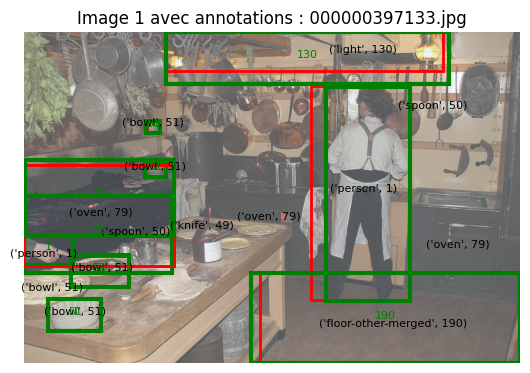

Valeurs d'IoU : [0.7368421052631579, 0.9094650205761317, 0.8432735047544028, 0.9172154280338665, 0.7279177881086372, 0.9543450257629805, 0.7612141652613827, 0.6412025812227237, 0.6682303094499508, 0.9612625538020086]
Vrais positifs (TP): 13
Faux positifs (FP): 3
Faux négatifs (FN): 11
PQ :  0.54918479414015


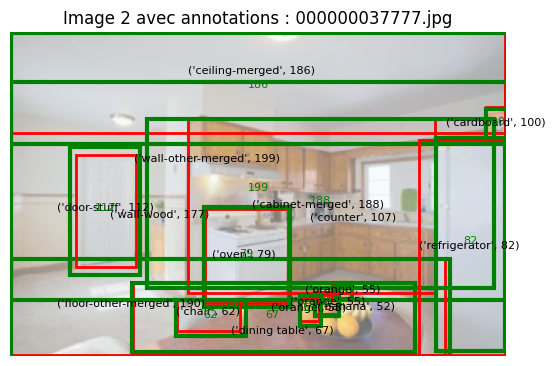

Valeurs d'IoU : [0.9127222350496421, 0.9334673559257132, 0.8961809551208285, 0.9971590909090909, 0.8953488372093024, 0.9728725380899294, 0.875, 0.7284768211920529, 0.7465934065934066, 0.6949040370615487, 0.7555555555555555, 0.792, 0.7834150500959284]


In [ ]:
# Boucle sur les images à afficher
for i in range(NUM_IMAGES_TO_DISPLAY):
    # Chargement des données de l'image
    image_data = coco.loadImgs(image_ids[i])[0]
    image_path = image_dir + image_data['file_name']

    # Chargement des annotations pour l'image
    annotations_ids = coco.getAnnIds(imgIds=image_data['id'])
    annotations = coco.loadAnns(annotations_ids)

    # Ouverture de l'image et conversion en RGB
    image = Image.open(image_path).convert("RGB")

    # Prétraitement de l'image avec le processeur
    inputs = image_processor(images=image, return_tensors="pt")

    # Passage de l'image à travers le modèle
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-traitement de la segmentation panoptique
    result = image_processor.post_process_panoptic_segmentation(outputs, target_sizes=[(image.height, image.width)])

    # Récupération de la segmentation panoptique et des informations sur les segments
    panoptic_seg = result[0]["segmentation"]
    panoptic_segments_info = result[0]["segments_info"]

    # Création de la figure et des axes pour afficher l'image
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')
    ax.set_title('Image {} avec annotations : {}'.format(i+1, image_data['file_name']) )

    # Conversion des catégories en dictionnaire
    label_id_to_name = {category['id']: category['name'] for category in coco.loadCats(coco.getCatIds())}

    # Initialisation de la liste des valeurs d'IoU
    iou_values = []

    # Initialisation des compteurs pour les TP, FP et FN
    TP = 0
    FP = 0
    FN = 0

    # Boucle sur les informations des segments panoptiques
    for segment_info in panoptic_segments_info:
        detected = False

        # Vérification du score du segment
        if segment_info['score'] > CONFIDENCE_THRESHOLD:
            label_id = segment_info['label_id']

            # Création du masque pour le segment
            mask = (panoptic_seg == segment_info['id']).cpu().numpy().astype(np.uint8)

            # Récupération du nom de la catégorie du segment
            label_name = ( label_id_to_name.get(label_id, str(label_id)) , label_id )

            # Calcul des coordonnées du centre du segment
            ys, xs = np.where(mask == 1)
            y_center = np.mean(ys)
            x_center = np.mean(xs)

            # Ajout du nom de la catégorie au centre du segment sur l'image
            ax.text(x_center, y_center, label_name, fontsize=8, color='black', ha='center')

            # Calcul des coordonnées du rectangle englobant
            ymin, xmin = np.min(ys), np.min(xs)
            ymax, xmax = np.max(ys), np.max(xs)
            pred_bbox = [xmin, ymin, xmax, ymax]
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

            # Récupération du masque du segment panoptique
            segment_mask = (result[0]['segmentation'] == segment_info['id'])
            nonzero_indices = torch.nonzero(segment_mask, as_tuple=True)

            # Calcul des coordonnées du rectangle englobant à partir du masque
            xmin = torch.min(nonzero_indices[1]).item()
            xmax = torch.max(nonzero_indices[1]).item()
            ymin = torch.min(nonzero_indices[0]).item()
            ymax = torch.max(nonzero_indices[0]).item()
            pred_bbox = [xmin, ymin, xmax, ymax]

            # Boucle sur les annotations pour comparer les bounding boxes
            for annotation in annotations:
                gt_bbox = annotation['bbox']
                if annotation['category_id'] == label_id and is_bbox_match(pred_bbox, gt_bbox):
                    ax.imshow(mask, alpha=0.05, cmap='Blues')
                    ax.add_patch(rect)
                    xmin = annotation['bbox'][0]
                    ymin = annotation['bbox'][1]
                    width = annotation['bbox'][2]
                    height = annotation['bbox'][3]
                    label_name_vrai = annotation['category_id']
                    ax.text((xmin + width//2), (ymin+height//2), label_name_vrai, fontsize=8, color='green', ha='center')
                    rectan = plt.Rectangle((xmin, ymin), width,height, linewidth=3, edgecolor='green', facecolor='none')
                    ax.add_patch(rectan)
                    iou = calculate_iou(pred_bbox, gt_bbox)
                    iou_values.append(iou)
                    detected = True
                    TP += 1

            if not detected:
                FP += 1

    FN = len(annotations) - TP
    print("Vrais positifs (TP):", TP)
    print("Faux positifs (FP):", FP)
    print("Faux négatifs (FN):", FN)
    PQ = calculate_PQ(TP, FP, FN, iou_values)
    print("PQ : ", PQ)

    plt.show()
    print("Valeurs d'IoU :", iou_values)
